**Upload the data in googledrive and mount drive**

In [1]:
# data source- https://www.kaggle.com/c/dog-breed-identification/data
# unzip the data
!unzip "/content/drive/MyDrive/dog-breed-identification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

**Imports**

In [125]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [126]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [127]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
from keras.models import Model, load_model
from keras.preprocessing import image

**Reading Data**

In [128]:
labels=pd.read_csv('/content/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [129]:
# filter selected breeds
selected_breeds=['beagle','chihuahua','doberman','french_bulldog','golden_retriever','malamute','pug','saint_bernard',
                 'scottish_deerhound','tibetan_mastiff']

In [130]:
# extracting specific classes
def filter_labels(df,selected_values,column='breed'):
    boolean_series=df[column].isin(selected_values)
    return df[boolean_series].reset_index(drop=True)

In [131]:
# append .jpg to id
def append_ext(fn):
    return fn+".jpg"

In [132]:
filtered_df=filter_labels(labels,selected_breeds)
filtered_df['id']=filtered_df['id'].apply(append_ext)
filtered_df.head()

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45.jpg,doberman
3,00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever


In [133]:
filtered_df.shape

(841, 2)

In [134]:
filtered_df['breed'].value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

**Train and Text Dataframes**

In [135]:
train, test = train_test_split(filtered_df, test_size=0.2)

In [136]:
train.reset_index(drop=True)
test.reset_index(drop=True)

,id,breed
0,c2956f64221e5f8ab9aef1540f47f7ac.jpg,beagle
1,2bf7c97c5bc83872492b744b46e39a9a.jpg,french_bulldog
2,40444f6d33053ad1b7e1f78b12f749c2.jpg,french_bulldog
3,12d1b8763a1b74c7e40c65b005f91ea9.jpg,french_bulldog
4,bf6cf509b2ee89fcc7f1b627ee1ed7e7.jpg,chihuahua
...,...,...
164,a2974cd29095193d21bad9d4429a0146.jpg,scottish_deerhound
165,4b532a761edf37dd9898b6bb7000476a.jpg,chihuahua
166,836962e1a82fcb77511051bb7ca5152d.jpg,malamute
167,e7faa5748d8320f604aeb3fd5bbe4ab0.jpg,saint_bernard


In [137]:
print(train.shape,test.shape)

(672, 2) (169, 2)


**Data Generators**

In [138]:
datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.1)

In [139]:
BATCH_SIZE = 32
train_dir='/content/train'
# test_dir='/content/test'
image_size=(224,224)

In [140]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=True,
    class_mode="categorical",
    target_size=image_size,
    color_mode="rgb" 
)

Found 605 validated image filenames belonging to 10 classes.


In [141]:
train_generator.class_indices

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}

In [142]:
validation_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=True,
    class_mode="categorical",
    target_size=image_size,
    color_mode="rgb"
)

Found 67 validated image filenames belonging to 10 classes.


In [143]:
test_generator=datagen.flow_from_dataframe(
    dataframe=test,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=True,
    class_mode="categorical",
    target_size=image_size,
    color_mode="rgb"
)

Found 169 validated image filenames belonging to 10 classes.


**Resnet50**

In [144]:
# resnet50
# identity block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor 
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.
    X_shortcut = X
    
    # First component 
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component  
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value and passing it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [145]:
# convolution block
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor 
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value
    X_shortcut = X


    # First component 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component  
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT  #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [146]:
def ResNet50(input_shape=(224, 224, 3), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [147]:
model = ResNet50(input_shape = (224, 224, 3), classes = 10)

In [148]:
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [149]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**early stopping, reducing learning rate, saving best model**

In [150]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min')

In [151]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

**Training**

In [44]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,
                     callbacks=[earlyStopping,mcp_save,reduce_lr_loss],
                    )

Epoch 1/40
18/18 [==============================] - 11s 609ms/step - loss: 0.0730 - accuracy: 0.9791 - val_loss: 5.7526 - val_accuracy: 0.3125
Epoch 2/40
18/18 [==============================] - 11s 622ms/step - loss: 0.0618 - accuracy: 0.9773 - val_loss: 5.5518 - val_accuracy: 0.4219
Epoch 3/40
18/18 [==============================] - 11s 625ms/step - loss: 0.0890 - accuracy: 0.9791 - val_loss: 5.0137 - val_accuracy: 0.3125
Epoch 4/40
18/18 [==============================] - 11s 622ms/step - loss: 0.0702 - accuracy: 0.9773 - val_loss: 5.5688 - val_accuracy: 0.3281
Epoch 5/40
18/18 [==============================] - 11s 616ms/step - loss: 0.1504 - accuracy: 0.9616 - val_loss: 3.7555 - val_accuracy: 0.3906
Epoch 6/40
18/18 [==============================] - 11s 612ms/step - loss: 0.1170 - accuracy: 0.9703 - val_loss: 4.7200 - val_accuracy: 0.3750
Epoch 7/40
18/18 [==============================] - 11s 616ms/step - loss: 0.0954 - accuracy: 0.9651 - val_loss: 4.4664 - val_accuracy: 0.2969

**Evaluation Metrics**

**Accuracy**

In [152]:
# load model
nm=tf.keras.models.load_model('/content/model.h5')

In [162]:
score=nm.evaluate(test_generator)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

6/6 [==============================] - 2s 364ms/step - loss: 1.4232 - accuracy: 0.7751
Accuracy: 77.51%
Loss:  1.4232420921325684


In [ ]:
# score = model.evaluate(test_generator)

**F1 score**

In [155]:
from sklearn.metrics import f1_score

In [156]:
Y_pred = nm.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
f_score = f1_score(test_generator.classes,y_pred,average='macro')
print('F1 score:',f_score)

F1 score: 0.08296598298571982


**Confusion Matrix**

In [187]:
import seaborn as sn
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [157]:
def labels_to_breed(label_array,generator_dict=train_generator.class_indices):
  inv_dict = {v: k for k, v in generator_dict.items()}
  breed_names=[]
  for i in label_array:
    breed_names.append(inv_dict[i])
  return breed_names

In [185]:
label=list(train_generator.class_indices.keys())
cm = confusion_matrix(labels_to_breed(test_generator.classes), labels_to_breed(y_pred))
print(cm)
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# # plt.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + label)
# ax.set_yticklabels([''] + label)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

[[3 2 0 1 3 3 1 2 3 0]
 [2 1 1 0 3 3 1 2 3 1]
 [2 2 0 0 1 3 2 1 4 0]
 [2 2 1 2 1 0 3 0 1 1]
 [1 0 1 3 0 1 2 0 1 0]
 [2 2 1 1 5 1 1 1 5 1]
 [2 1 2 1 0 1 1 1 5 2]
 [1 2 4 1 2 3 2 2 4 0]
 [2 4 4 3 1 1 3 2 7 2]
 [3 2 1 0 0 1 1 1 2 0]]


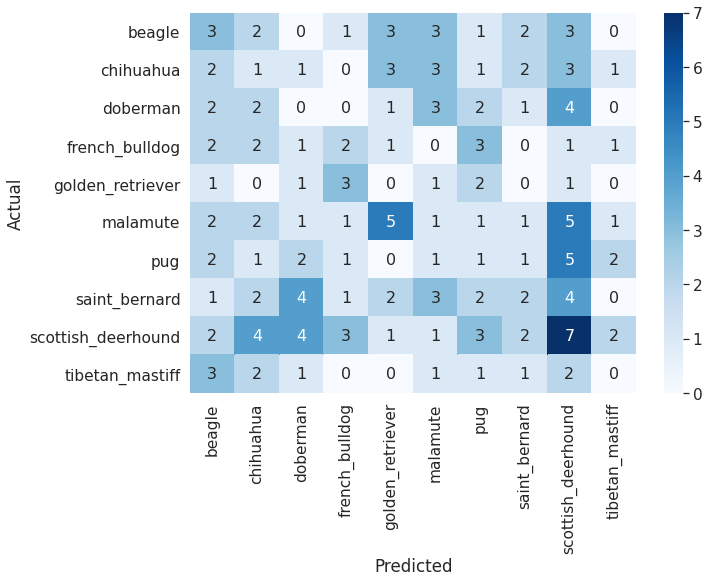

In [188]:
df_cm = pd.DataFrame(cm, columns=np.unique(labels_to_breed(test_generator.classes)), index = np.unique(labels_to_breed(test_generator.classes)))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

**ROC Curve**

In [189]:
from sklearn.metrics import roc_curve, auc

In [206]:
n_classes=10

In [207]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(list(test_generator.classes), list(y_pred), pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [211]:
# inverse dictionary of train_generator.class_indices
inv_dict = {v: k for k, v in train_generator.class_indices.items()}

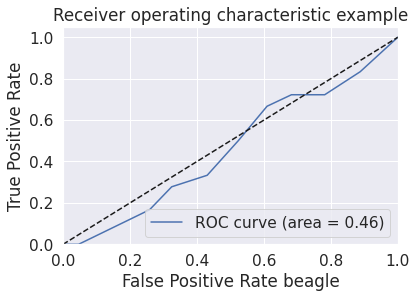

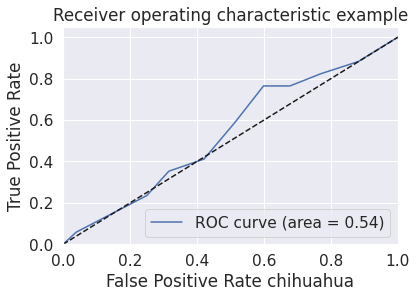

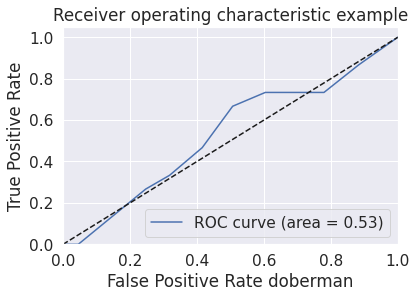

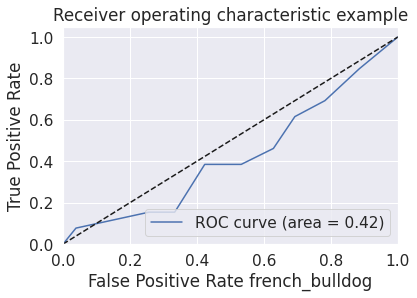

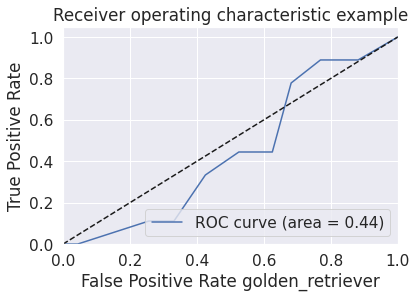

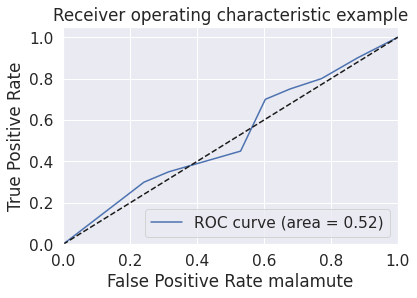

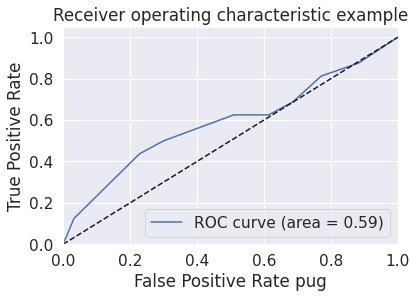

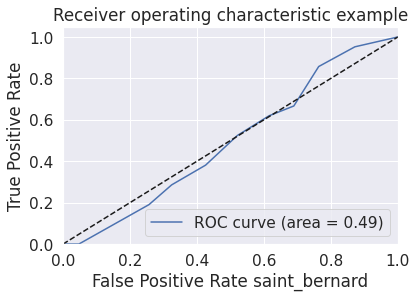

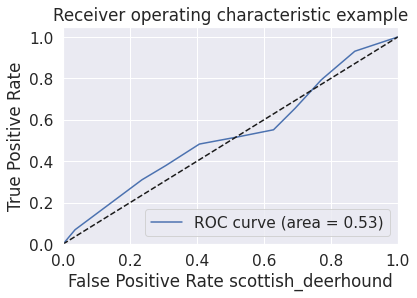

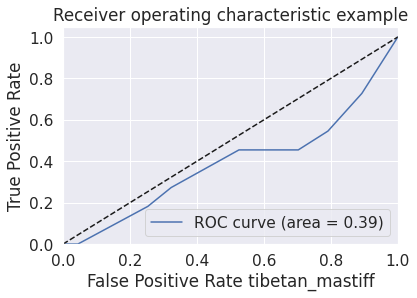

In [213]:
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'+' '+inv_dict[i])
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()